## ARIMA

ARIMA原理：将非平稳时间序列转化为平稳时间序列然后将因变量仅对它的滞后值以及随机误差项的现值和滞后值进行回归所建立的模型

### ARIMA 建模流程
  
1. 数据的平稳性检验:利用 ARMA 模型建模必须确保数据具有平稳性，除了看趋势图，另外采用定量分析的 ADF 检验(单位根检验)。  
2. 平稳性处理:对于非平稳数据需进行平稳化处理，否则忽略此步骤。如果数据具有明显的趋势，一般去除趋势采取对数并差分，具有季节性采取差分处理 或者建立季节性模型。  
3. 定阶:更具差分次数确定𝑑。根据自相关系数(ACF)和偏自相关系数(PACF)图、AIC 准则确定𝑝, 𝑞。  
4. 模型参数估计:最大似然估计或者最小二乘估计。确立参数并检查估计参数的显著性。  
5. 残差分析:好的 ARIMA 模型尽量拟合线性成分，残差表现为白噪声。对残差进行 Q(Ljung-Box)统计量分析。

In [1]:
%reload_ext autoreload
%matplotlib inline

import logging
import warnings
from pathlib import Path 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Settings
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
 
# seaborn plotting style
sns.set(style='ticks', context='poster')


# Constants
logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')
warnings.filterwarnings('ignore')

data_root = Path(r'/home/liuzhi/test/data')

### 1. 加载数据

In [2]:
data = pd.read_csv(f'{data_root}/ak_usd-cny.csv')
data.head()

,Date,C,O,H,L,P
0,2021-01-29,6.45990,6.45630,6.46060,6.45600,0.00160
1,2021-01-28,6.44960,6.49150,6.49400,6.44920,-0.00500
2,2021-01-27,6.48220,6.46160,6.48810,6.45770,0.00290
3,2021-01-26,6.46350,6.47700,6.47850,6.46230,-0.00230
4,2021-01-25,6.47840,6.48500,6.48700,6.47210,-0.00040


### 2. 确定所需的时间序列

In [3]:
time_series = data.C 

### 3. 画图，观察数据

<AxesSubplot:>

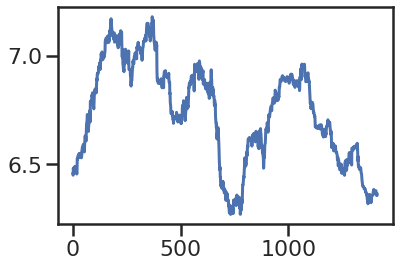

In [4]:
time_series.plot()

### 4. ADF检验 - 确定数据为平稳时间序列

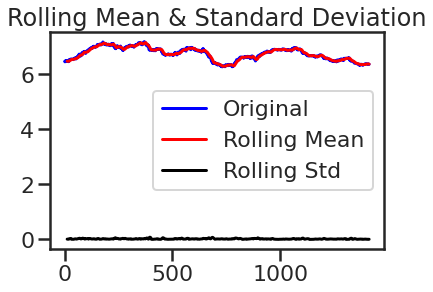

Results of Augment Dickey-Fuller Test:
Test Statistic                  -1.25583
p-value                          0.64913
#Lags Used                       5.00000
Number of Observations Used   1408.00000
Critical Value (1%)             -3.43500
Critical Value (5%)             -2.86359
Critical Value (10%)            -2.56786
dtype: float64


In [6]:
'''
进行ADF检验
adf_test的返回值
Test statistic：代表检验统计量
p-value：代表p值检验的概率
Lags used：使用的滞后k，autolag=AIC时会自动选择滞后
Number of Observations Used：样本数量
Critical Value(5%) : 显著性水平为5%的临界值。
(1)假设是存在单位根，即不平稳；
(2)显著性水平，1%：严格拒绝原假设；5%：拒绝原假设，10%类推。
(3)看P值和显著性水平a的大小，p值越小，小于显著性水平的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的
(4)看检验统计量和临界值，检验统计量小于临界值的话，就拒绝原假设，认为序列是平稳的；大于的话，不能拒绝，认为是不平稳的
'''
from statsmodels.tsa.stattools import adfuller

def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = time_series.rolling(window=12).std()
 
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
 

def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
    print ('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value   #增加后面的显著性水平的临界值
    print (dfoutput)
    
adf_test(time_series)

如果数据不平稳，则做Log操作，并做一阶差分。

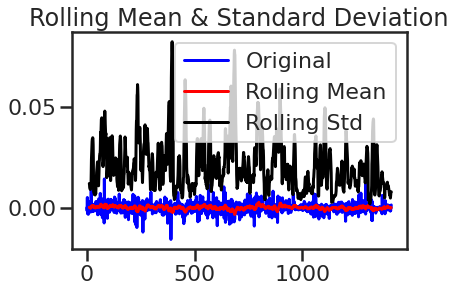

Results of Augment Dickey-Fuller Test:
Test Statistic                 -17.22095
p-value                          0.00000
#Lags Used                       3.00000
Number of Observations Used   1410.00000
Critical Value (1%)             -3.43500
Critical Value (5%)             -2.86359
Critical Value (10%)            -2.56786
dtype: float64


In [8]:
data['ts_log'] = np.log(data.C)
ts_log = data.ts_log
ts_log_diff = data.ts_log.diff(1)
ts_log_diff = ts_log_diff.fillna(0)

adf_test(ts_log_diff)

### 5. 白噪声检验 - 检验数据是否具有相关性

In [9]:
'''
acorr_ljungbox(x, lags=None, boxpierce=False)函数检验无自相关
lags为延迟期数，如果为整数，则是包含在内的延迟期数，如果是一个列表或数组，那么所有时滞都包含在列表中最大的时滞中
boxpierce为True时表示除开返回LB统计量还会返回Box和Pierce的Q统计量
返回值：
lbvalue:测试的统计量
pvalue:基于卡方分布的p统计量
bpvalue:((optionsal), float or array) – test statistic for Box-Pierce test
bppvalue:((optional), float or array) – p-value based for Box-Pierce test on chi-square distribution
'''

from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_cnt, ljung_box_p = acorr_ljungbox(ts_log_diff, lags = 20) 
print(ljung_box_cnt)
print(ljung_box_p)  # 从结果可以看出，p值较小，拒绝原假设（没有相关性），故数据有序列相关性

[ 2.95024  3.18976  5.94823  9.7105  11.41517 11.5754  12.05378 12.07232
 14.77347 15.66426 15.83929 18.45065 18.57507 18.78867 20.31174 21.35736
 22.78307 23.38197 29.49131 35.90957]
[0.08586 0.20293 0.11416 0.0456  0.04374 0.07214 0.0988  0.14801 0.09735
 0.10966 0.1472  0.10268 0.13688 0.17318 0.1603  0.16518 0.15645 0.17634
 0.05864 0.01576]


### 6. 确定AR和MA的阶数

In [15]:
##借助AIC、BIC统计量自动确定
from statsmodels.tsa.arima_model import ARMA

def optim_arma(p_val, q_val): 
    ts =ts_log_diff
    p = int(round(p_val))
    q = int(round(q_val))

    model = ARMA(ts, order=(p, q))
    try:
        results_ARMA = model.fit(disp=-1, method='css')
    except:
        return -1e9
    bic = results_ARMA.bic    
    return -bic

In [16]:
from bayes_opt import BayesianOptimization

params = {
    'p_val': (0, 20),
    'q_val': (0, 20)
}

bayes_arma = BayesianOptimization(optim_arma, params)
bayes_arma.maximize(n_iter=100)

|   iter    |  target   |   p_val   |   q_val   |
-------------------------------------------------
|  1        |  1.28e+04 |  9.677    |  7.866    |
|  2        |  1.286e+0 |  1.918    |  18.7     |
|  3        |  1.288e+0 |  7.31     |  2.634    |
|  4        |  1.265e+0 |  16.7     |  14.1     |
|  5        |  1.285e+0 |  2.035    |  19.79    |
|  6        |  1.299e+0 |  0.0      |  0.0      |
|  7        |  1.297e+0 |  0.0      |  5.275    |
|  8        |  1.299e+0 |  0.01136  |  0.7331   |
|  9        |  1.299e+0 |  0.01136  |  0.7331   |
|  10       |  1.299e+0 |  0.0      |  2.091e-0 |
|  11       |  1.299e+0 |  0.08482  |  0.07692  |
|  12       |  1.269e+0 |  20.0     |  0.0      |
|  13       |  1.296e+0 |  2.202    |  0.05258  |
|  14       |  1.293e+0 |  0.0      |  10.89    |
|  15       |  1.291e+0 |  3.273    |  7.228    |
|  16       |  1.297e+0 |  1.188    |  3.054    |
|  17       |  1.299e+0 |  0.187    |  0.02918  |
|  18       |  1.299e+0 |  0.2391   |  1.191e-0 |


In [17]:
bayes_arma.max

{'target': 12992.838524562481, 'params': {'p_val': 0.0, 'q_val': 0.0}}

### 7. 拟合ARIMA或者ARMA模型

Text(0.5, 1.0, 'RSS: 0.008356160583791444')

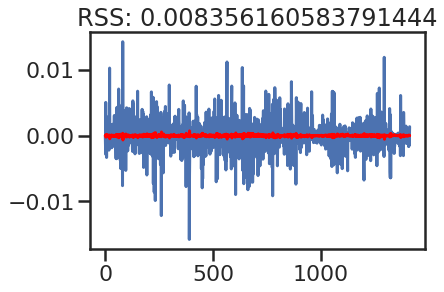

In [18]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log_diff, order=(1, 0, 0))
results_ar = model.fit(disp=-1)

plt.plot(ts_log_diff)
plt.plot(results_ar.fittedvalues, color='red')
plt.title(f'RSS: {sum((results_ar.fittedvalues-ts_log_diff)**2)}')  # 残差平方和

### 8. 检验模型效果： 残差检验

1. QQ图：QQ-plot(Q代表分位数Quantile)是一种通过画出分位数来比较两个概率分布的图形方法。首先选定区间长度，点(x,y)对应于第一个分布(x轴)的分位数和第二个分布(y轴)相同的分位数。因此画出的是一条含参数的曲线，参数为区间个数。如果被比较的两个分布比较相似，则其QQ图近似地位于y=x上。如果两个分布线性相关，则QQ图上的点近似地落在一条直线上，但并不一定是y=x这条线。QQ图同样可以用来估计一个分布的位置参数。残差检验中：横坐标为正态分布的分位数，纵坐标为残差的分位数。

2. 德宾-沃森（Durbin-Watson）检验。德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。并且  
    - DW＝O＝＞ρ＝１　　 即存在正自相关性  
    - DW＝４＜＝＞ρ＝－１　即存在负自相关性  
    - DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性  
因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验。

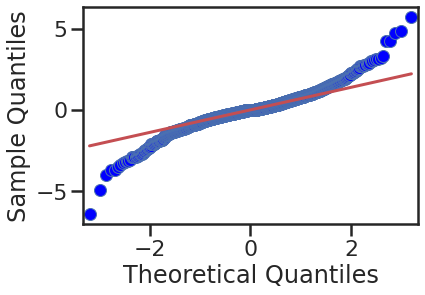

In [20]:
# 如果残差是白噪声序列，说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的。
# 残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。
# 如果残差如果未通过白噪声检验，说明残差中还有有用的信息，需要修改模型或者进一步提取。

from statsmodels.graphics.api import qqplot

resid = results_ar.resid
qqplot(resid, line='q', fit=True)
plt.show()

# qq图中：如果是正态分布则为一条直线，即红线。结果大致符合白噪声。

In [21]:
# 白噪声检验除了qq图还可以使用DW检验法（DW：检验残差序列是否具有自相关性，只适用一一阶自相关；多阶自相关可用LM检验）

import statsmodels.api as sm

print(sm.stats.durbin_watson(resid.values))

1.9988444561853889


### 9. 预测

In [22]:
# 从训练集第0个开始预测(start=1表示从第0个开始)，预测完整个训练集后，还需要向后预测10个

forecast_n = 10

forecast_ar = results_ar.forecast(forecast_n)
forecast_ar = forecast_ar[0]

print(forecast_ar)  # 有负数，表明是一阶差分之后的

[-0.00007 -0.00001 -0.00001 -0.00001 -0.00001 -0.00001 -0.00001 -0.00001
 -0.00001 -0.00001]


In [35]:
# 预测的平稳值还原为非平稳序列

result_log_fina = np.array(pred[0:-10]) + (np.array(ts_log_diff.shift(1)))
result_fina = np.exp(result_log_fina)
result_fina

array([    nan, 1.00006, 0.99818, ..., 0.99847, 0.99993, 0.99998])